In [4]:
# Imports
%matplotlib inline
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings

In [5]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

Instructions for updating:
non-resource variables are not supported in the long term


In [6]:
# file path to dataset file"
f_path = "cardio_train.csv"

df = pd.read_csv(f_path,sep = ';',index_col=0)

## PreProcessing Data

In [7]:
'''
cut the necessary information out of the dataset
'''
df2 = df[['age','gender','height','weight','smoke']]
df2['gender'] = df2['gender'].replace({1:0,2:1})

In [8]:
'''
normalization of the data
'''
df2['age'] = df['age'].apply(lambda x: x/360)

In [9]:
'''
0 - female
1 - male
'''
df2,df2['gender'].value_counts()

(             age  gender  height  weight  smoke
 id                                             
 0      51.091667       1     168    62.0      0
 1      56.188889       0     156    85.0      0
 2      52.380556       0     165    64.0      0
 3      48.952778       1     169    82.0      0
 4      48.538889       0     156    56.0      0
 ...          ...     ...     ...     ...    ...
 99993  53.444444       1     168    76.0      1
 99995  62.780556       0     158   126.0      0
 99996  52.961111       1     183   105.0      0
 99998  62.308333       0     163    72.0      0
 99999  57.055556       0     170    72.0      0
 
 [70000 rows x 5 columns],
 0    45530
 1    24470
 Name: gender, dtype: int64)

In [39]:
'''
split the dataset into training_set 50K
and testing_set 20K
'''
training_set = df2.iloc[-20000:]
testing_set = df2.iloc[50000:]

In [59]:
'''
4 features = [age, weight, height, smoke]
'''
features = 4
alpha = 0.0004
# placeholders are a bunch of empty nodes in a graph, waiting to be filled
# None -> allow num of examples to be dynamic size
# X and Y represnt matrices
X = tf.placeholder(tf.float32,[None,features])
Y = tf.placeholder(tf.float32, [None, 1])

# Trainable Variable Weights
W = tf.Variable(tf.zeros([features,1]))
  
# Trainable Variable Bias
b = tf.Variable(tf.zeros([1]))

In [60]:
# Hypothesis
y_ = tf.add(tf.matmul(X, W), b)
  
# Sigmoid Cross Entropy Cost Function
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                    logits = y_, labels = Y))
  
# Gradient Descent Optimizer
update = tf.train.GradientDescentOptimizer(alpha).minimize(loss)

In [61]:
'''
transform training data into numpy array so it meets the wanted dimensions
'''
data_x = training_set.drop(columns='gender').to_numpy() #matrix of vectors, each vectors has 4 attributes
data_y = training_set.drop(columns=['age', 'weight','height','smoke']).to_numpy() #matrix of vectors, each vector has 1 attribute

In [62]:
# confirm dimensions
data_x, data_y

(array([[ 52.525     , 176.        ,  72.        ,   0.        ],
        [ 64.66111111, 145.        ,  68.        ,   0.        ],
        [ 58.8       , 159.        ,  66.        ,   0.        ],
        ...,
        [ 52.96111111, 183.        , 105.        ,   0.        ],
        [ 62.30833333, 163.        ,  72.        ,   0.        ],
        [ 57.05555556, 170.        ,  72.        ,   0.        ]]),
 array([[1],
        [0],
        [1],
        ...,
        [1],
        [0],
        [0]], dtype=int64))

In [63]:
steps = 100000
with tf.Session() as sess:
    # sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    for i in range(steps):
        sess.run(update,feed_dict={X: data_x, Y : data_y})
        if i%10000 == 0:
            print('Iteration: ',i)
            # eval evaluates the value of a variable. Therefore, K. eval(loss) gives you the value of the crossentropy loss
            print('W:\n ',sess.run(W), '\nb:\n ', sess.run(b), '\nLoss:\n ',loss.eval(session=sess, feed_dict={X:data_x,Y:data_y}))
    Weight = sess.run(W) # Optimized Weight
    Bias = sess.run(b)   # Optimized Bias
    print('final W: ',sess.run(W))
    print('final b: ',sess.run(b))
    print('final Loss: ',loss.eval(session=sess, feed_dict={X:data_x,Y:data_y}))

Iteration:  0
W:
  [[-3.1616129e-03]
 [-8.6827502e-03]
 [-3.8116816e-03]
 [ 1.2859999e-05]] 
b:
  [-5.762e-05] 
Loss:
  0.83308977
Iteration:  10000
W:
  [[-0.13197866]
 [ 0.01715978]
 [ 0.00890671]
 [ 0.16051593]] 
b:
  [-0.03869498] 
Loss:
  1.2840309
Iteration:  20000
W:
  [[-0.13121419]
 [ 0.01711758]
 [ 0.00880742]
 [ 0.31557688]] 
b:
  [-0.07695431] 
Loss:
  1.2766824
Iteration:  30000
W:
  [[-0.13041434]
 [ 0.01707444]
 [ 0.00870856]
 [ 0.4659539 ]] 
b:
  [-0.11508641] 
Loss:
  1.2691458


KeyboardInterrupt: 

In [33]:
'''
preparing for testing, checking results using confusion matrix
text_x - 20k examples 
test_y - 20k labels
'''
test_x = testing_set.drop(columns='gender').to_numpy()
test_y = testing_set.drop(columns=['age', 'weight','height','smoke']).to_numpy()

#logistic regression function for prediction
# z is a vector containing 4 features [age, height, weight, smoke]
def logistic_fun(z):
    return 1/(1.0+np.exp(-z))

# predicted will be a vector of the prediction of the testing_set
predicted = []

#looping each vector in text_x matrix
for vec in test_x:
    pr = logistic_fun(np.matmul([vec],sess.run(W))+sess.run(b))
    predicted.append(1) if pr >= 0.5 else predicted.append(0)       

In [34]:
'''
peparing labeled data for the confusion matrix
'''
actual = test_y.flatten()

In [37]:
y_actu = pd.Series(actual, name='Actual')
y_pred = pd.Series(predicted, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred,rownames=['Actual'], colnames=['Predicted'], margins=True)

In [38]:
df_confusion

Predicted,0,1,All
Actual,,,
0,11862,1019,12881
1,5535,1584,7119
All,17397,2603,20000


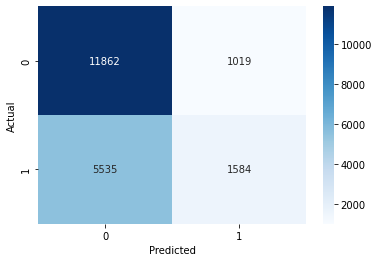

In [56]:
'''
We let the model predict some samples and then show on a confusion matrix plot the results.
All results such as classification report, confusion matrix and plot, are saved into a 
time stamped directory under reports/ 
'''
predictions = predicted
true_labels = actual
cf_matrix = pd.crosstab(y_actu, y_pred)

heatmap = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

In [57]:
accuracy = np.sum(np.equal(actual,predicted))/len(actual)